# CIFAR10 - subset

Base on the previous result of trying to classify CIFAR10 dataset, now I take a closer look at a subset of CIFAR10. In other words, I train on 4 classes that are quite similar to each other (cat, deer, dog, horse).

## Prepare Dataset

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

import pathlib
data_dir = pathlib.Path("data")

train_data = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
import numpy as np
import random

#str targets --> idx targets
target_classes = ['cat', 'deer', 'dog', 'horse']

def get_selective_subset(data, target_classes, num_to_get):
  class_indexes = data.class_to_idx
  targets = [class_indexes[target] for target in target_classes] 

  indices = []
  for idx, t in enumerate(data.targets):
    if t in targets:
      indices.append(idx)
  
  random.shuffle(indices)
  indices = indices[:int(num_to_get * len(indices))]
  labels = [data.targets[i] for i in indices]
  
  return custom_subset(data, indices, labels, target_classes)

train_dataset = get_selective_subset(train_data, target_classes, 0.1)
test_dataset = get_selective_subset(test_data, target_classes, 0.1)

map_target = {subset_y: new_y for new_y, subset_y in enumerate(np.unique(train_dataset.targets))}
train_dataset.targets = list(map(lambda x: map_target[x], train_dataset.targets))
test_dataset.targets = list(map(lambda x: map_target[x], test_dataset.targets))

horse


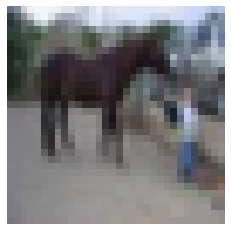

In [ ]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(train_dataset))
class_names = train_dataset.classes

print(class_names[train_dataset[idx][1]])
img=train_dataset[idx][0].permute(1,2,0)
plt.imshow(img)
plt.axis(False);

## DataLoader

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH = 128
num_cpu = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=num_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=True, num_workers=num_cpu)

## Model

In [ ]:
from torch import nn

class CIFAR10Classifier(nn.Module):
  def __init__(self, input_shape: int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.cnn_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.cnn_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*8*8*2, out_features=hidden_units*8*2),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units*8*2, out_features=output_shape))
    
  def forward(self, x):
    x = self.cnn_block_1(x)
    # print(x.shape)
    x = self.cnn_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

## Train step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
  model.train()
  train_loss, train_acc = 0, 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    y_logits = model(X)

    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    train_acc += (y_pred == y).sum().item() / len(y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss/len(dataloader), train_acc/len(dataloader)

## Test step

In [ ]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: torch.nn.Module,
              device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      test_loss += loss_fn(y_logits).item()

      y_pred = y_logits.softmax(dim=-1).argmax(dim=-1)
      test_acc += (y_pred == y).sum().item() / len(y)

    return test_loss / len(dataloader), test_acc / len(dataloader)

## Train func

In [ ]:
from tqdm.auto import tqdm

def train_func(model: nn.Module,
               train_dataloader: DataLoader,
               test_dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               epochs : int, device):
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, 
                                      loss_fn, optimizer, device)
    test_loss, test_acc = train_step(model, train_dataloader, 
                                      loss_fn, optimizer, device)
    print(f'Epoch: {epoch}  | Train loss: {train_loss : .4f} | Train Acc: {train_acc:.2f} | Test loss {test_loss:.4f} | Test Acc {test_acc:.2f}')

## Train

In [ ]:
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 25

model = CIFAR10Classifier(input_shape=3, output_shape=len(target_classes), hidden_units=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

from timeit import default_timer as timer
start_time = timer()
train_func(model, train_dataloader, test_dataloader, loss_fn, optimizer, EPOCHS, device)
end_time = timer()

print(f"Total training time: {end_time-start_time:.4f} seconds")

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 0  | Train loss:  1.4056 | Train Acc: 0.29 | Test loss 1.3868 | Test Acc 0.25
Epoch: 1  | Train loss:  1.3884 | Train Acc: 0.29 | Test loss 1.3606 | Test Acc 0.34
Epoch: 2  | Train loss:  1.3105 | Train Acc: 0.39 | Test loss 1.2709 | Test Acc 0.42
Epoch: 3  | Train loss:  1.2592 | Train Acc: 0.42 | Test loss 1.1920 | Test Acc 0.46
Epoch: 4  | Train loss:  1.1611 | Train Acc: 0.48 | Test loss 1.1225 | Test Acc 0.50
Epoch: 5  | Train loss:  1.0827 | Train Acc: 0.52 | Test loss 1.0782 | Test Acc 0.52
Epoch: 6  | Train loss:  1.0192 | Train Acc: 0.56 | Test loss 0.9696 | Test Acc 0.58
Epoch: 7  | Train loss:  0.9377 | Train Acc: 0.59 | Test loss 0.8966 | Test Acc 0.61
Epoch: 8  | Train loss:  0.8841 | Train Acc: 0.62 | Test loss 0.8337 | Test Acc 0.65
Epoch: 9  | Train loss:  0.8266 | Train Acc: 0.66 | Test loss 0.7833 | Test Acc 0.68
Epoch: 10  | Train loss:  0.7221 | Train Acc: 0.72 | Test loss 0.6873 | Test Acc 0.73
Epoch: 11  | Train loss:  0.6322 | Train Acc: 0.75 | Test loss 0

## Predict

Predict: dog True: dog


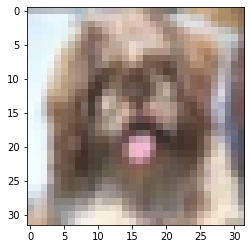

In [ ]:
import random
idx = random.randint(0, len(test_dataset))
img, label = test_dataset[idx]

model.to(device)
model.eval()
with torch.inference_mode():
  y_logit = model(img.unsqueeze(0))
  y_pred = y_logit.softmax(dim=-1).argmax(dim=-1)

print("Predict:",target_classes[y_pred.item()], "True:", target_classes[label])
plt.imshow(img.permute(1,2,0));